# How to measure energy of a particle experimentally?

In particle physics, Calorimeters are particle detectors that measure the energy of a particle. When particles passes through matter, it create a shower of secondary particles (Read more at https://en.wikipedia.org/wiki/Particle_shower) and deposits energy. The deposited energy is then recorded by the read out electronics and corrected depending how much energy has been sampled.


# Hadronic Calorimeter detector 

The hadronic calorimeter is designed for future sPHENIX experiment. It is a steel-scintillator sampling calorimeter with two longitudinal segments, the inner and outer HCal. More details can be found at https://arxiv.org/abs/1704.01461.

Below is an analysis of the data collected by a hadronic calorimeter prototype at Fermi National Laboratory, Chicago. The full detector is designed to be 100 times bigger than this prototype and become a part of sPHENIX experiment at Brookhaven National Laboratory. The prototype had total 32 towers in two longitudinal segments of 4x4 array.

<img src='hcal_drawing.png' style="width: 40%; height: 40%">

Most of these codes were originally written in C++ with ROOT data analysis software (https://root.cern.ch/). Below is a demonstration in python. Git repository for the C++ version of the data analysis software can be found at:
https://github.com/sPHENIX-Collaboration/analysis/tree/master/Prototype2/HCAL/ShowerCalib

# Data Format
32 Tower sensors were read out at each event. The beam is a mixture of hadron and electron particles. The purpose of the Hadronic Calorimeter is to measure the energy of hadronic showers. The energy of the incoming particle is known but not its species. There was an additional detector available at the test beam facility called Cherenkov detector (https://en.wikipedia.org/wiki/Cherenkov_detector). Electrons passed through Cherenkov detector emits a high signal while hadrons dont. Some terminology:
1. Event: Each event is one incident particle to our experimental setup. At the end of each event read out electronics records the signal from all the detector sensors and dumps to disk. Each row in the Pandas dataframe below corresponds to one event collected.
2. Run: A collection of events with a particular setup of the experiment.
3. Beam momentum: The energy of the incoming particle.
4. C2_sum: Signal from the Cherenkov detector. High signal indicate electron, otherwise it is a hadron. Sometimes electrons get missed by the detector rising a contamination in hadron sample.
5. hcalin_twr_e: The inner HCal tower energies. 16 read outs from 4x4 towers.
6. hcalout_twr_e: The outer HCal tower energies. 16 read outs from 4x4 towers.


# Objectives
1. Data exploration.
2. Understanding detector performance for hadron and electrons separately.
3. Optimize the tower weights numerically for a better performance.
4. Build a classification model for hadron and electron separation.
5. Dimention reduction and visualize the data in lower dimention.
6. Calorimeter performance as a function of input energy.

I originally had data in ROOT files. So I am going to load the data using "root_numpy" module which is an interface between ROOT and numpy (https://pypi.python.org/pypi/root_numpy). 


In [1]:
from root_numpy import tree2array
from ROOT import TFile
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import leastsq
import seaborn as sns
import operator as op
from scipy import stats
from scipy.optimize import minimize
import math

Welcome to ROOTaaS 6.06/08


Lets first look into the input folder.

In [2]:
from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))

Prototype_pionn_12.root
Prototype_pionn_16.root
Prototype_pionn_24.root
Prototype_pionn_32.root
Prototype_pionn_8.root



5 files corresponds to 5 different energies: 8, 12, 16, 24 and 32 GeV. Lets start with 16 GeV data file and at the end we will look at all energies together. 

In [3]:
filename = 'input/Prototype_pionn_16.root'
rfile = TFile(filename)
intree = rfile.Get('T')
variables = ['run','beam_mom','C2_sum','hcalin_twr_e','hcalout_twr_e']
myarray = tree2array(intree,branches=variables)
df = pd.DataFrame(myarray.tolist(), columns=variables)
df.shape

TClass::Init:0: RuntimeWarning: no dictionary for class Proto2ShowerCalib::Eval_Run is available
TClass::Init:0: RuntimeWarning: no dictionary for class Proto2ShowerCalib::HCAL_shower is available


(167204, 5)

In [4]:
df.head()

,run,beam_mom,C2_sum,hcalin_twr_e,hcalout_twr_e
0,3730,-16.0,-0.019210,"[-0.00265980022959, -0.00462330272421, -0.0037...","[-0.0212302021682, -0.0184601247311, 0.0162082..."
1,3730,-16.0,-0.551397,"[-0.00691356416792, 0.00586697971448, 0.003307...","[0.010158309713, 0.0527120679617, 0.8358482718..."
2,3730,-16.0,359.499847,"[0.00296210846864, 0.0130761666223, 0.01332342...","[0.0144229764119, 0.00840053055435, -0.0099206..."
3,3730,-16.0,-2.053645,"[0.0166303664446, 0.0260916631669, 0.040534138...","[0.0170602612197, -0.0147548737004, 0.02767019..."
4,3730,-16.0,1.471208,"[-0.00317231588997, -0.00269385124557, 0.00277...","[0.0223745349795, -0.0149723319337, -0.0114196..."


Lets start with "C2_sum" variable. It is the signal from Cherenkov detector.

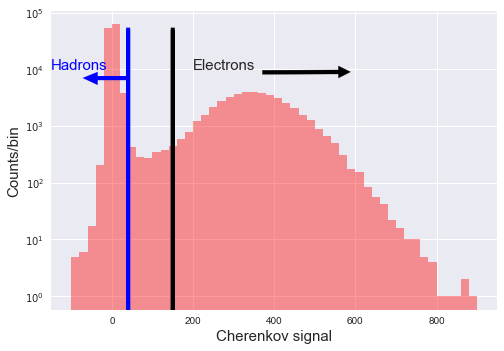

In [5]:
fig = sns.distplot(df['C2_sum'],hist=True, kde=False, hist_kws={"range": [-100,900]}, color='red')
plt.gca().set_yscale('log')
plt.xlabel("Cherenkov signal", fontsize=15)
plt.ylabel("Counts/bin", fontsize=15)
plt.annotate('Electrons', xy=(600, 9e3), xytext=(200, 1e4), fontsize=15,
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.arrow(150, 0, 0, 5e4, head_width=0, head_length=0, color='black', lw=4)
plt.text(-150,1e4,r"Hadrons",fontsize=15, color='blue')
plt.arrow(40, 0, 0, 5e4, head_width=0, head_length=0, color='blue', lw=4)
plt.arrow(40, 7e3, -80, 0, head_width=2000, head_length=20, color='blue', lw=4)

As you can see above Cherenkov detector has a broad signal above 150 counts for electrons. Event with no signal close to zero are hadrons. You might ask why the signal is negative? It is because of the noise. A physicist/engineer would call it the pedestal flactuations. "Pedestal" means the measured value of an electrical component with no output. We define two new variables "good_e" and "good_h" when Cherenkov signal >150 and <10. For the signal in between we are not sure.

Lets look into our calorimeter data. Two new variables are introduced "hcalin_sum" and "hcalout_sum" by summing all 4x4 towers for inner and outer HCal separately. Some of the values for "hcalin_twr_e" and "hcalout_twr_e" are negative. Thats perfectly alright, it is because of pedestal flactuation.

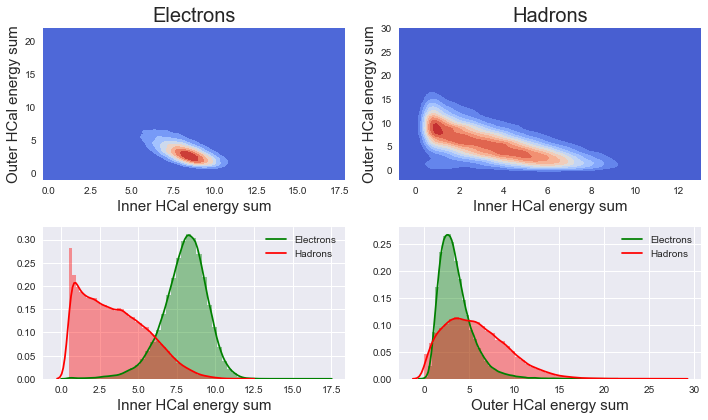

In [6]:
df['good_e'] = df['C2_sum'].apply( lambda x: x>150)
df['good_h'] = df['C2_sum'].apply( lambda x: x<10 )

df['hcalin_sum'] = df['hcalin_twr_e'].apply(lambda x: sum(x))
df['hcalout_sum'] = df['hcalout_twr_e'].apply(lambda x: sum(x))

df = df[df['hcalin_sum']>0.5]
df = df[df['hcalout_sum']>0]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,6))
#plot electrons
plot_data = df[df['good_e']]
sns.kdeplot(plot_data["hcalin_sum"], plot_data["hcalout_sum"], shade=True, cut=5, cmap='coolwarm', ax=ax1)
ax1.set_xlabel("Inner HCal energy sum",fontsize=15)
ax1.set_ylabel("Outer HCal energy sum",fontsize=15)
ax1.set_title("Electrons",fontsize=20)
sns.distplot(plot_data['hcalin_sum'], color='green', kde_kws={"label": "Electrons"}, ax=ax3)
sns.distplot(plot_data['hcalout_sum'], color='green', kde_kws={"label": "Electrons"}, ax=ax4)

#plot Hadrons
plot_data = df[df['good_h']]
sns.kdeplot(plot_data["hcalin_sum"], plot_data["hcalout_sum"], shade=True, cut=5, cmap='coolwarm', ax=ax2)
ax2.set_xlabel("Inner HCal energy sum", fontsize=15)
ax2.set_ylabel("Outer HCal energy sum", fontsize=15)
ax2.set_title("Hadrons",fontsize=20)
sns.distplot(plot_data['hcalin_sum'], color='red', kde_kws={"label":"Hadrons"}, ax=ax3)
ax3.set_xlabel("Inner HCal energy sum", fontsize=15)
sns.distplot(plot_data['hcalout_sum'], color='red', kde_kws={"label":"Hadrons"}, ax=ax4)
ax4.set_xlabel("Outer HCal energy sum", fontsize=15)
plt.tight_layout()

The above shows how the energy is distributed between two segments of the calorimeter. We learn something fundamental about electromagnetic and hadronic showers. Electrons deposit most of the energies in the inner segment while hadrons deposits most of energies in the outer segment. 

Lets make a new variable which is the asymmetry between the two segments.

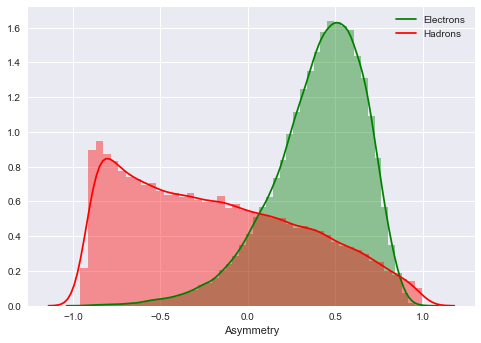

In [7]:
df['Asymmetry'] = df.apply(lambda x:(x['hcalin_sum']-x['hcalout_sum'])/(x['hcalin_sum']+x['hcalout_sum']), axis=1)

sns.distplot(df[df['good_e']]['Asymmetry'], color='green', kde_kws={"label": "Electrons"})
sns.distplot(df[df['good_h']]['Asymmetry'], color='red', kde_kws={"label": "Hadrons"})

Great. Electrons deposit most of energies in the inner HCal, hence asymmetry close to 1. Hadrons on the other hand has a peak close to -1 but have a broad distribution.

Lets look into which towers contain most of the energies. We can look into a heatmap of the 4x4 towers.

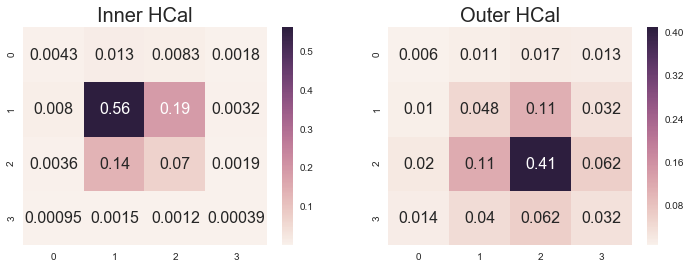

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
hcalin_twr_sum = df['hcalin_twr_e'].sum()
hcalin_twr_sum = hcalin_twr_sum/sum(hcalin_twr_sum)
sns.heatmap(hcalin_twr_sum.reshape(4,4),annot=True, annot_kws={"size": 16}, ax=ax1)
ax1.set_title("Inner HCal", fontsize=20)

hcalout_twr_sum = df['hcalout_twr_e'].sum()
hcalout_twr_sum = hcalout_twr_sum/sum(hcalout_twr_sum)
sns.heatmap(hcalout_twr_sum.reshape(4,4),annot=True, annot_kws={"size": 16}, ax=ax2)
ax2.set_title("Outer HCal", fontsize=20)

Almost 50% of the energy deposited in just one tower. This is expected because beam was narrow enough and the setup didn't change while data taking. I wouldnt worry about the (1,1) tower in inner HCal vs (2,2) tower in outer HCal has the most of the energy. This is due to non-trivial geometry of the calorimeter and their alignment, you can read more about geometry in the arXiv paper.

Now lets look into the total energy, combining both the sections.

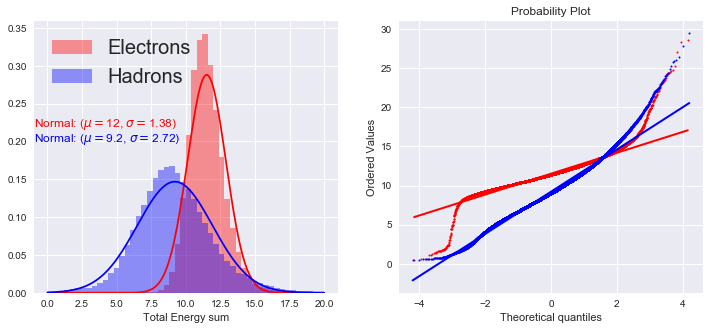

In [9]:
df = df[df['good_e'] | df['good_h']]
df['sum_e'] = df['hcalin_sum'] + df['hcalout_sum']

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
#for electrons
sns.distplot(df[df['good_e']]['sum_e'], kde=False, color='red', fit=stats.norm,  label="Electrons", hist_kws={"range":[0,20]}, fit_kws={"clip":[0,20],"color":'red'},  ax=ax1)
(mu, sigma) = stats.norm.fit(df[df['good_e']]['sum_e'])
ax1.text(-1., 0.22, "Normal: ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma),fontsize=12, color='red')
res = stats.probplot(df[df['good_e']]['sum_e'], plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('r')
ax2.get_lines()[0].set_markersize(2.0)
ax2.get_lines()[1].set_linewidth(2.0)

#for hadrons
sns.distplot(df[df['good_h']]['sum_e'], kde=False, color='blue', fit=stats.norm, label="Hadrons", hist_kws={"range":[0,20]}, fit_kws={"clip":[0,20],"color":'blue'}, ax=ax1)
ax1.legend(loc='best', fontsize=20)
(mu, sigma) = stats.norm.fit(df[df['good_h']]['sum_e'])
ax1.text(-1., 0.20, "Normal: ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma),fontsize=12, color='blue')
ax1.set_xlabel("Total Energy sum")
res = stats.probplot(df[df['good_h']]['sum_e'], plot=ax2)
ax2.get_lines()[2].set_markerfacecolor('b')
ax2.get_lines()[2].set_markersize(2.0)
ax2.get_lines()[3].set_color('b')
ax2.get_lines()[3].set_linewidth(2.0)


The left plot above shows the individual peaks for electrons and hadrons. Electron peak location is slightly higher than the hadrons and it is expected. It is intrinsic to the detector material. In physics it is called e/h response and always more than 1. Another important observation is the width of the hadron showers is higher than the electron showers. This is also a well known fact in physics community. 

The plot on the right is the probability plot which shows if the data follows the fitted curve. The data are plotted against a theoretical distribution in such a way that the points should form approximately a straight line. Departures from this straight line indicate departures from the specified distribution. Except for the two end, the data mostly follows the straight line. So far so good.

However recall this data is for 16 GeV input energy. The means for both particles are not even close to where they should be. This is because data needs to be calibrated. Due to inconsistencies in detector material, electronics, dust and other physical reasons the response of the individual towers are not exactly the same. So we need to equalize the tower responses. One way to do it is to get a set of weights for all the towers and optimize the total energy response  to the input energy. This process is slower, so we will optimize over 1000 good hadron samples. The idea is to minimize the difference between input and reconstructed energy.

Optimization terminated successfully.
         Current function value: 14228.611754
         Iterations: 35
         Function evaluations: 15565
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [ -7.74272185e-06,   6.17953752e-05,   9.29275767e-06, ...,
         -1.28872884e-06,   3.00647695e-06,   1.69368087e-05]])
     fun: 14228.61175410959
 message: 'Optimization

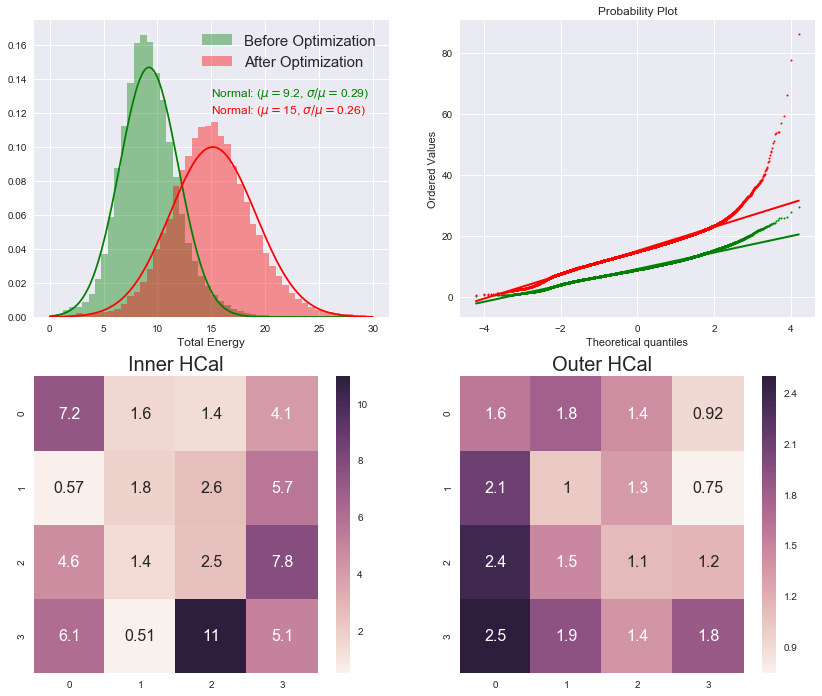

In [10]:
dfs = df[df['good_h']].sample(1000) #take a sample
c = [1. for i in xrange(32)] #initial weights

#calculate (Output - Expected)^2
def optfunc(E,hin_twr_e,hout_twr_e,weights):
    hin_e = sum(map(op.mul,hin_twr_e,weights[:16]))
    hout_e= sum(map(op.mul,hout_twr_e,weights[16:]))
    return (hin_e + hout_e + E)**2

#finally apply the weights
def final_apply(row,weights):
    hin_e = sum(map(op.mul,row['hcalin_twr_e'],weights[:16]))
    hout_e= sum(map(op.mul,row['hcalout_twr_e'],weights[16:]))
    return hin_e + hout_e

#minimization function
def minfunc(c):
    return sum(dfs.apply(lambda x: optfunc(x['beam_mom'],x['hcalin_twr_e'],x['hcalout_twr_e'],c),axis=1))
    
result = minimize(minfunc,c,method='Powell',options={'disp': True,'ftol':0.0, 'maxiter':30000, 'maxfev':30000})
print result

df['totE'] = df.apply(final_apply,weights=result.x,axis=1)

f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(14,12))
sns.distplot(df[df['good_h']]['sum_e'], kde=False, color='green', fit=stats.norm,  label="Before Optimization", hist_kws={"range":[0,30]}, fit_kws={"clip":[0,30],"color":'green'},  ax=ax1)
(mu, sigma) = stats.norm.fit(df[df['good_h']]['sum_e'])
ax1.text(15, 0.13, "Normal: ($\mu=${0:.2g}, $\sigma/\mu=${1:.2f})".format(mu, sigma/mu),fontsize=12, color='green')

res = stats.probplot(df[df['good_h']]['sum_e'], plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('green')
ax2.get_lines()[0].set_markersize(2.0)
ax2.get_lines()[1].set_linewidth(2.0)
ax2.get_lines()[1].set_color('green')

sns.distplot(df[df['good_h']]['totE'], kde=False, color='red', fit=stats.norm,  label="After Optimization", hist_kws={"range":[0,30]}, fit_kws={"clip":[0,30],"color":'red'},  ax=ax1)
(mu, sigma) = stats.norm.fit(df[df['good_h']]['totE'])
ax1.text(15, 0.12, "Normal: ($\mu=${0:.2g}, $\sigma/\mu=${1:.2f})".format(mu, sigma/mu),fontsize=12, color='red')
ax1.set_xlabel("Total Energy", fontsize=12)
ax1.legend(loc='best', fontsize=15)

res = stats.probplot(df[df['good_h']]['totE'], plot=ax2)
ax2.get_lines()[2].set_markerfacecolor('r')
ax2.get_lines()[2].set_markersize(2.0)
ax2.get_lines()[3].set_linewidth(2.0)

#plt.subplot(1,3,2)
sns.heatmap(result.x[:16].reshape(4,4),annot=True, annot_kws={"size": 16}, ax=ax3)
ax3.set_title("Inner HCal", fontsize=20)

#plt.subplot(1,3,3)
sns.heatmap(result.x[16:].reshape(4,4),annot=True, annot_kws={"size": 16}, ax=ax4)
ax4.set_title("Outer HCal", fontsize=20)


After optimization it looks much better. The mean is closer to where it is expected to be. Sigma/mean is also decreased. The optimization code runs much slower in python. I have a C++ version which runs over all the data pretty quickly. The abover excercise shows how scipy.optimize can be used for weights optimization.

The heatmap of the weights looks interesting. The above optimization is unbounded but it can be run bounded as well. One tower in inner HCal needs to weighted by 8.4 which is very high but remember those towers has very less energy. If you look into the 4 middle towers, on an average, inner HCal needs a weight of 2 while outer HCal it is close to 1. 

Next we are goint to try some classification. The original separation between hadron/electrons were provided by the Cherenkov detector which is not part of our experiment design. It is an external device just for this setup. In our actual experiment we have to distinguish a hadron event from an electron event by looking into how energy is deposited in our towers only.

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Running:  Nearest Neighbors
BEST PARAMS {'n_neighbors': 25}
Accuracy on training sample: 0.92
Accuracy on test sample:     0.92
confusion matrix on test sample: 
[[1016  103]
 [  56  825]]
Running:  RBF SVM
BEST PARAMS {'C': 0.5, 'gamma': 0.01}
Accuracy on training sample: 0.92
Accuracy on test sample:     0.92
confusion matrix on test sample: 
[[974 100]
 [ 61 865]]
Running:  Ada Boost
BEST PARAMS {'n_estimators': 150}
Accuracy on training sample: 0.91
Accuracy on test sample:     0.92
confusion matrix on test sample: 
[[983  98]
 [ 68 851]]
Running:  Random Forest
BEST PARAMS {'n_estimators': 70, 'min_samples_leaf': 10}
Accuracy on training sample: 0.93
Accuracy on test sample:     0.91
confusion matrix on test sample: 
[[992 114]
 [ 63 831]]


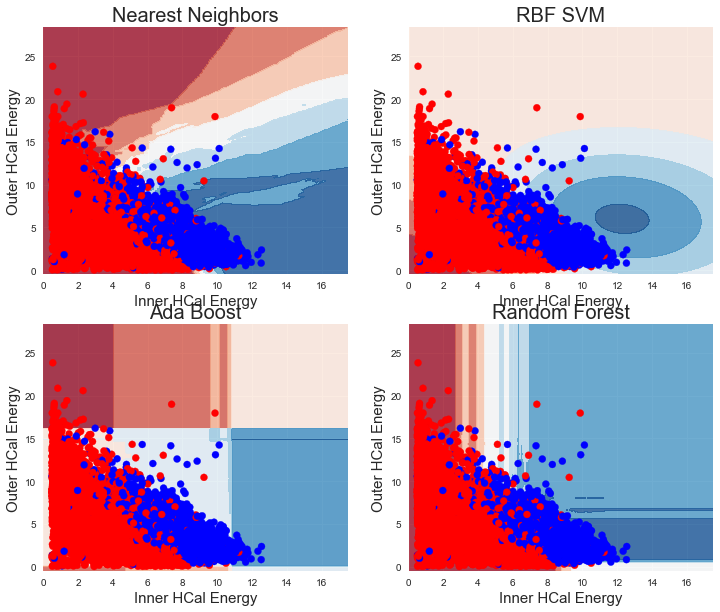

In [11]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import manifold
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=indf[targetname].values
    y = y.reshape((len(y)))
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training sample: %0.2f" % (training_accuracy)
    print "Accuracy on test sample:     %0.2f" % (test_accuracy)
    print 'confusion matrix on test sample: ' 
    print confusion_matrix(ytest, clf.predict(Xtest))
    return clf

df = df[df['good_e'] | df['good_h']]
dfs = df.sample(10000)

xcolumns = ['hcalin_sum','hcalout_sum']
target = ['good_e']

names = ["Nearest Neighbors", "RBF SVM", "Ada Boost", "Random Forest"]

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    AdaBoostClassifier(),
    RandomForestClassifier(),
    ]

param_grids = [
    {"n_neighbors": [10,15,25]},
    {"C": [0.1, 0.5, 1.], "gamma":[0.01, 0.1, 0.5]},
    {"n_estimators": [70, 100, 150] },
    {"n_estimators": [70, 100, 150], "min_samples_leaf":[4, 10, 15]},
]

figure = plt.figure(figsize=(12, 10))
for i, (name, clf, par) in enumerate(zip(names,classifiers,param_grids)):
    print 'Running: ', name
    clf_fit = do_classify(clf, par, dfs, xcolumns, target)
    ax = plt.subplot(2, 2, i+1)
    ax.set_title(name, fontsize=20)
    xx, yy = np.meshgrid(np.arange(df['hcalin_sum'].min()-0.5,df['hcalin_sum'].max()+0.5,0.1),
                         np.arange(df['hcalout_sum'].min()-0.5,df['hcalout_sum'].max()+0.5,0.1))
    if hasattr(clf, "decision_function"):
        Z = clf_fit.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf_fit.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.contourf(xx,yy,Z,cmap=cm,alpha=0.8)
    ax.scatter(dfs['hcalin_sum'], dfs['hcalout_sum'], c=dfs['good_e'], cmap=cm_bright)
    ax.set_xlabel('Inner HCal Energy', fontsize=15)
    ax.set_ylabel('Outer HCal Energy', fontsize=15)

As you see above, four classifiers were tried our data. Each classifiers were trained on the training data and cross-validated. The cross-validation also tunes our hyper-parameters if provided. The average accuracy is around 90%, printed for each classifiers. 

Last but not the least lets try a dimention reduction technique. We have 32 features corresponds to 32 towers (2 segments of 4x4 array). Without just adding all the towers, can we project the data to a lower dimention and see if we can see any pattern. Here we are going to use MDS from scikit-learn. But.. Data needs to flatten out first. So lets seperate each towers and make them individual columns. 

In [12]:
colnames = ['hcalin_twr_%i'%i for i in xrange(16)]
colnames.extend(['hcalout_twr_%i'%i for i in xrange(16)])

def flatten_columns(row):
    cols = {}
    for i in xrange(16):
        cols[colnames[i]] = row['hcalin_twr_e'][i]
        cols[colnames[i+16]] = row['hcalout_twr_e'][i]
    cols['good_h'] = row['good_h']
    return pd.Series(cols)

dfs = df.sample(1000)
df_flat = dfs.apply(flatten_columns,axis=1)
df_flat.head()

,good_h,hcalin_twr_0,hcalin_twr_1,hcalin_twr_10,hcalin_twr_11,hcalin_twr_12,hcalin_twr_13,hcalin_twr_14,hcalin_twr_15,hcalin_twr_2,...,hcalout_twr_14,hcalout_twr_15,hcalout_twr_2,hcalout_twr_3,hcalout_twr_4,hcalout_twr_5,hcalout_twr_6,hcalout_twr_7,hcalout_twr_8,hcalout_twr_9
35487,True,0.002004,-0.005653,0.227287,-0.000662,0.003012,-0.002728,-0.004513,-0.002261,-0.004988,...,-0.004071,0.981405,0.018997,0.010181,-0.013790,0.013023,-0.010908,-0.009853,2.876707,0.037078
131884,True,0.009311,0.022979,0.105788,-0.002224,0.003049,0.005221,-0.004197,-0.004282,0.002671,...,0.052494,-0.002832,0.021514,-0.130530,0.009485,0.703751,1.608654,0.019501,0.052797,0.263943
40488,False,0.004529,0.022479,0.642387,-0.002596,0.003636,0.002795,0.004079,-0.001318,0.003531,...,0.137301,-0.005722,0.080834,-0.007891,-0.026393,0.021602,0.200185,-0.017041,0.012802,0.624702
23874,False,-0.003651,0.007886,0.309004,0.001015,-0.002488,0.008660,-0.005741,0.003316,-0.000860,...,-0.018487,0.271253,-0.009987,0.034036,-0.023200,0.230558,0.105531,0.148553,0.104397,0.334681
111128,True,0.101998,0.383058,0.102128,-0.002046,-0.003773,-0.001399,-0.003464,-0.002611,0.006955,...,0.024616,-0.025346,0.050962,0.030219,-0.007691,0.156760,0.090586,0.879057,0.009181,0.479254


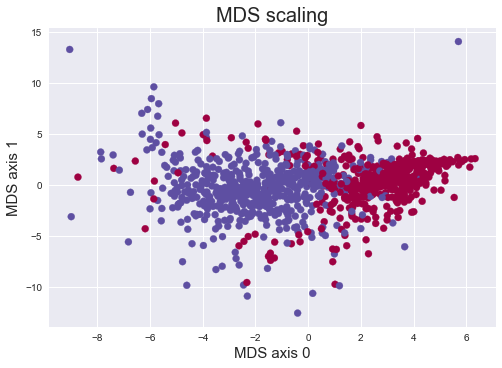

In [13]:
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS

X = df_flat[colnames]
y = df_flat['good_h']
res = pdist(X, 'euclidean')
similarity = squareform(res)

mds = MDS(n_components=2, max_iter=100, n_init=1, dissimilarity='precomputed')
df_trans = mds.fit_transform(similarity)
plt.scatter(df_trans[:, 0], df_trans[:, 1], c=y.values, cmap=plt.cm.Spectral)
plt.title("MDS scaling", fontsize=20)
plt.xlabel("MDS axis 0", fontsize=15)
plt.ylabel("MDS axis 1", fontsize=15)

Wow. This nicely shows the 32 dimentional data in 2 dimention. The distance is precomputed with scipy's pdist function. MDS (Multidimentional scaling) basically project the euclidean distances in two dimention. Two colors represents hadrons and not-hadrons events.

We are almost done. We have explored the 16 GeV data fully. Now lets see how the energy dependence looks like. The data were saved in separate file for each energy. Lets apply the precomputed weights to all the energies and see how calorimeter responses in all energies.

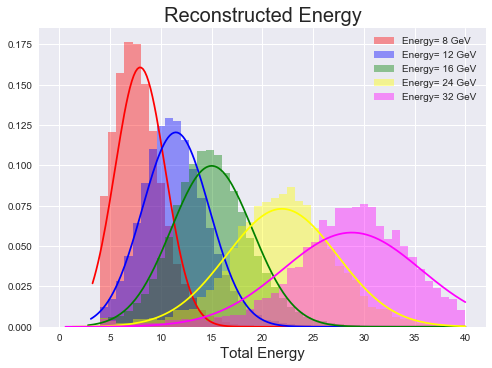

In [14]:
energy_files = [
    "input/Prototype_pionn_8.root",
    "input/Prototype_pionn_12.root",
    "input/Prototype_pionn_16.root",
    "input/Prototype_pionn_24.root",
    "input/Prototype_pionn_32.root"
]

energies = [8, 12, 16, 24, 32]
variables = ['run','beam_mom','C2_sum','hcalin_twr_e','hcalout_twr_e']
color = ['red', 'blue', 'green', 'yellow', 'magenta']
hadron_mean = []
hadron_sigma = []

for en,filename,c in zip(energies,energy_files,color):
    rfile = TFile(filename)
    intree = rfile.Get('T')
    myarray = tree2array(intree,branches=variables)
    df = pd.DataFrame(myarray.tolist(), columns=variables)
    df['good_e'] = df['C2_sum'].apply( lambda x: x>150)
    df['good_h'] = df['C2_sum'].apply( lambda x: x<10 )
    df['totE'] = df.apply(final_apply,weights=result.x,axis=1)
    df = df[df['totE']>4]
    sns.distplot(df[df['good_h']]['totE'], kde=False, color=c, fit=stats.norm,  label="Energy= %i GeV"%en, hist_kws={"range":[0,40]}, fit_kws={"clip":[0,40],"color":c})
    (mu, sigma) = stats.norm.fit(df[df['good_h']]['totE'])
    hadron_mean.append(mu)
    hadron_sigma.append(sigma)
    
plt.title("Reconstructed Energy", fontsize=20)
plt.xlabel("Total Energy", fontsize=15)
plt.legend(loc='best', fontsize=10)

That looks very nice. We have successfully reconstructed particle energies. 

If you are still following, you now know how to reconstruct a particle experimentally. Remember this is still very preliminary. What happens when you thousands of towers? What happens if hundreds of particles deposit energies at the same time? How would you calibrate your detector? 

Now, finally, lets look into how the detector response looks like as function of input energies.

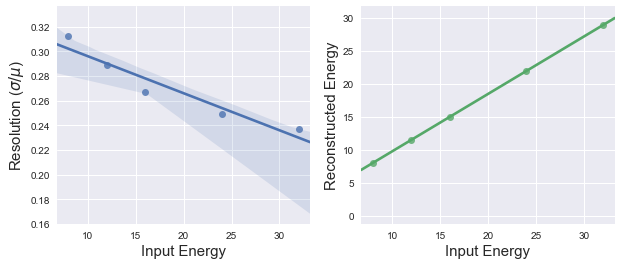

In [15]:
resolution = [sigma/mean for mean,sigma in zip(hadron_mean,hadron_sigma)]
f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
sns.regplot(np.array(energies,dtype=np.float), np.array(resolution,dtype=np.float), ax=ax1)
ax1.set_xlabel("Input Energy", fontsize=15)
ax1.set_ylabel("Resolution ($\sigma/\mu$)", fontsize=15)
sns.regplot(np.array(energies,dtype=np.float), np.array(hadron_mean,dtype=np.float), ax=ax2)
ax2.set_xlabel("Input Energy", fontsize=15)
ax2.set_ylabel("Reconstructed Energy", fontsize=15)

Plot on the left above is called the resolution plot. Although I used a linear regression plot (using sns.regplot), it is not expected to be linear at all. The plot on the right shows the reconstructed energy as a function of input energy. It should be linear for a good detector and it is.


Thats it. Thanks for visiting.